# Multiprocessing test

In [28]:
%%writefile out.py
import multiprocessing as mp
import logging
import sys
import time

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger(__name__)

def worker(queue):
    logger.info('hi')
    queue.put(1)
    return 

if __name__ == '__main__':
    logger.info('hey')
    
    with mp.Pool(4) as pool, mp.Manager() as m:
        queue = m.Queue()
        pool.apply_async(worker, (queue,))
        pool.apply_async(worker, (queue,))
        pool.close()
        pool.join()
        print(queue.get(False, 1))

Overwriting out.py


In [29]:
! python out.py

INFO:__main__:hey
INFO:__mp_main__:hi
INFO:__mp_main__:hi
1


# Polite Webscraper of UCI Datasets
1. Fetch Webpage
2. Fetch Downloads with Normcurved 
3. Fetch Webpage subsets

In [7]:
import sched
import numpy as np
import requests
import bs4
import urllib
import os
from collections import deque

# the folder that information will be stored in
save_folder = 'data'

# in this context, has no benefit over time.sleep - just using for practice
s = sched.scheduler()

urls = [
    r'https://archive.ics.uci.edu/ml/datasets/Abalone',
    r'https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29',
    r'https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29',
    r'https://archive.ics.uci.edu/ml/datasets/Japanese+Credit+Screening',
    r'https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE',
    r'https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients',
    r'https://archive.ics.uci.edu/ml/datasets/Credit+Approval'
]


# a simple queue using deques (deque = double ended queue)
# deque's are threadsafe and have O(1) performance of pop's and appends in either direction
q = deque(urls)

def handle_response(url):
    '''
    :param: test
    '''
    url_path = urllib.parse.urlparse(url)[2]
    resp = requests.get(url)
    soup = bs4.BeautifulSoup(resp.text, 'lxml')

    # handle top level
    if url_path.split('/')[-2] == 'datasets':
        data_folder = soup.find('a', text="Data Folder")
        if data_folder is None: 
            raise Exception("Did not find data folder. Perhaps api change")

        # get relative url
        data_folder = data_folder.attrs['href']

        # merge into absolute url
        data_folder = urllib.parse.urljoin(url, data_folder)
        q.append(data_folder)

    # handle folder download
    else:

        # folder
        if resp.url.endswith('/'): 
            _found_parent_dir = False
            for row in soup.find('table').find_all('tr'):
                # only save results below parent dir
                if not _found_parent_dir: 
                    if row.find('td', text='Parent Directory') is not None:
                        _found_parent_dir = True
                    continue

                child_link = row.find('a', href=True)
                if child_link is None: continue 

                child_link = child_link.attrs['href']
                child_link = urllib.parse.urljoin(resp.url, child_link)

                q.append(child_link)

        # file
        else:
            local_folder = os.path.join(save_folder, *url_path.split('/')[3:-1])
            local_path = os.path.join(save_folder, *url_path.split('/')[3:])

            # don't overwrite exact files
            if os.path.exists(local_path): return
            
            if not os.path.exists(local_folder):
                os.makedirs(local_folder)
                
            with open(local_path, 'wb') as f:
                for chunk in resp.iter_content(chunk_size=1024): 
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)

class display_loading:
    def __init__(self, f):
        self.a = 0
        self.m = 3
        self.f = f
        
    def __call__(self):
        self.a += 1 
        self.a = self.a % self.m
        print('.' * self.a, end='\r')
        self.f()

@display_loading
def polite_webscraper():
    try:
        item = q.popleft()
    except IndexError:
        print('done')
        return # No URLs left in queue.
    
    handle_response(item)

    delay = abs(np.random.normal(2.0, 0.25))
    s.enter(delay, 1, polite_webscraper)
    s.run()
    
polite_webscraper()

done..........


In [133]:
! python -m pip install -U pip setuptools

Requirement already up-to-date: pip in c:\users\wolf\anaconda3\lib\site-packages
  Found existing installation: setuptools 25.1.6
    Uninstalling setuptools-25.1.6:
      Successfully uninstalled setuptools-25.1.6


In [2]:
%load_ext Cython

In [4]:
%%cython -a

cdef int a = 0
for i in range(10):
    a += i
print(a)

45


## Plot Delay Times

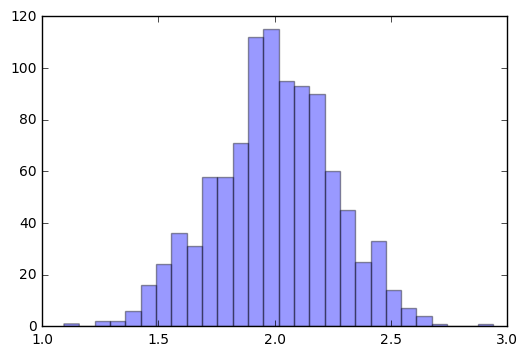

In [68]:
%matplotlib inline
import seaborn as sb
a = np.random.normal(2.0, 0.25, 1000)
sb.distplot(a, kde=False)